## Задание 1. Задачи с цепями

### Модель №1 (соскальзывание без сопротивления)

Однородная цепь длиной 2.45 м соскальзывает с гладкого горизонтального стола. В начальный момент наблюдения со стола свисал конец цепи длиной 0.3 м. Считая ускорение свободного падения равным 9.8 м/с² и пренебрегая трением цепи о поверхность стола, найдите **время** соскальзывания всей цепи со стола, если в начале наблюдения скорость соскальзывания цепи составила 1 м/с.

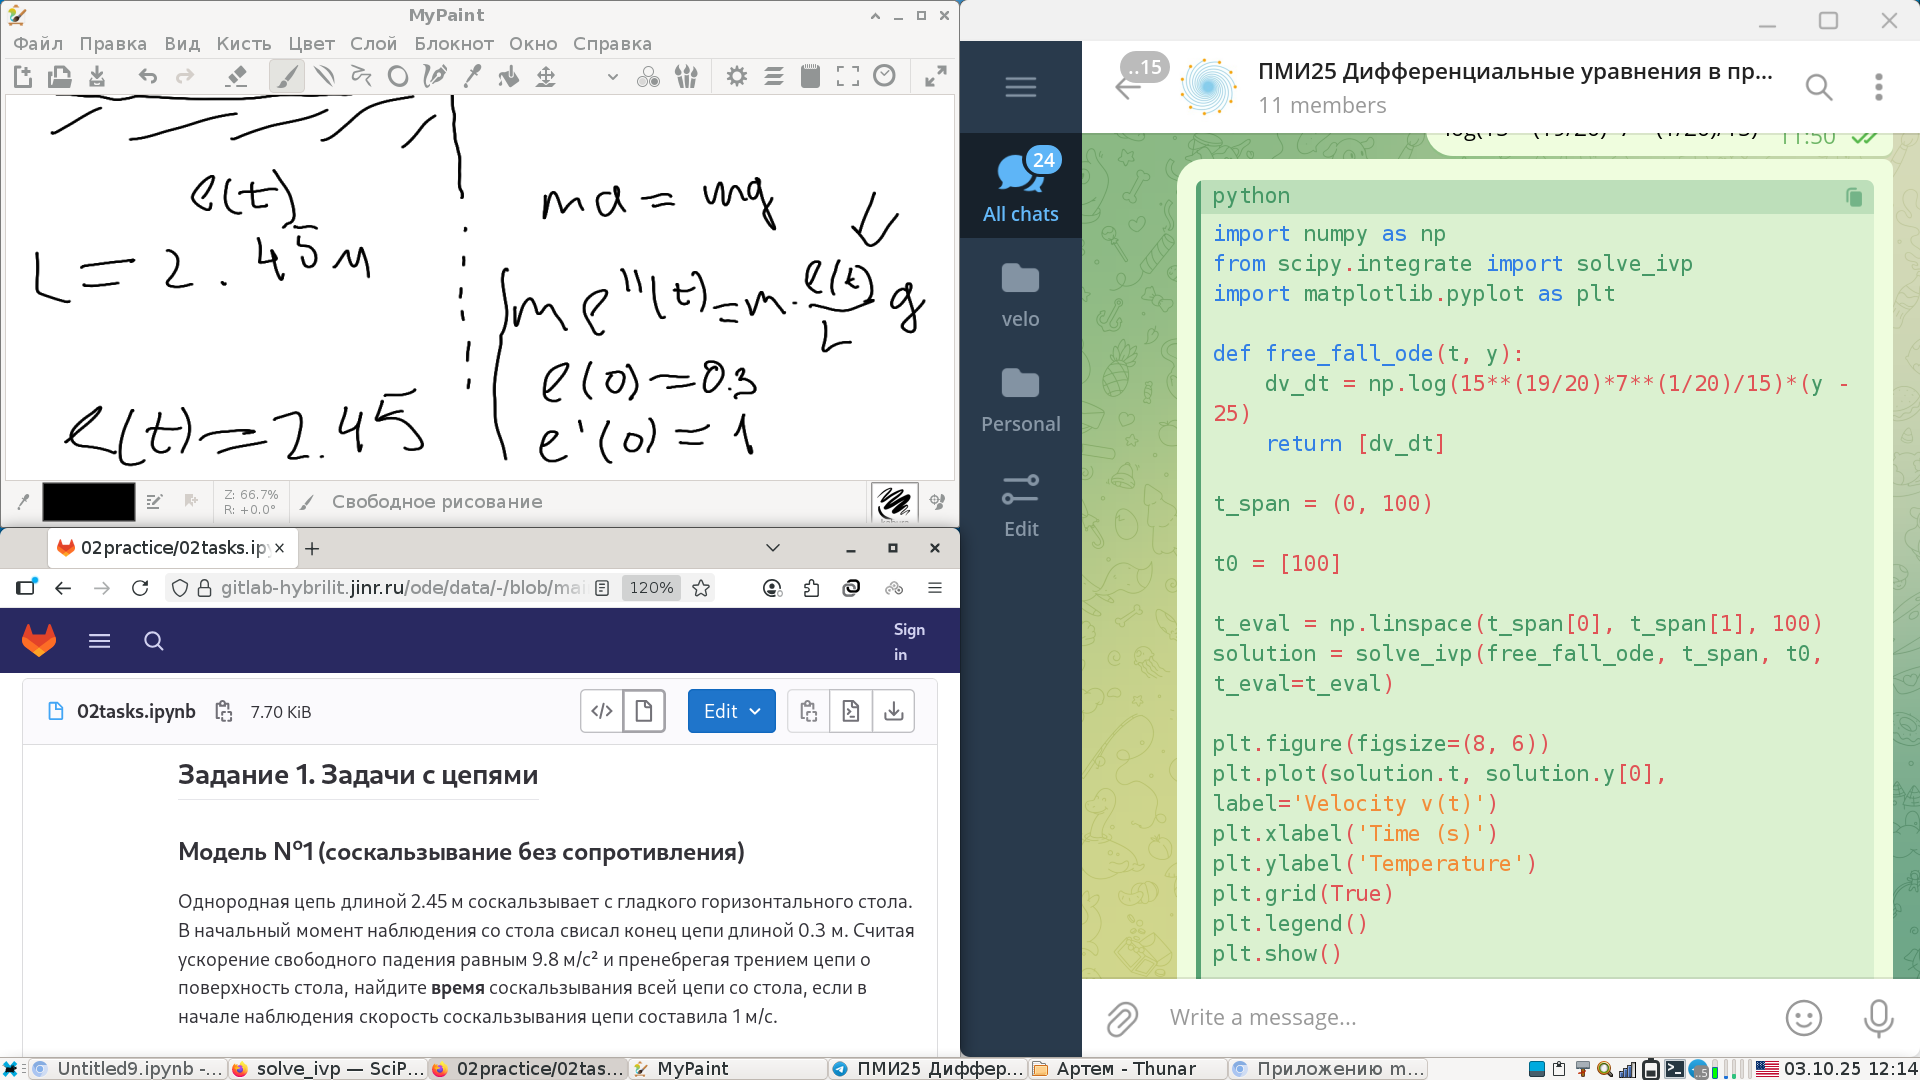

In [1]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
# Начальные условия
L = 2.45
l0 = 0.3
g = 9.8
v0 = 1

t, m = symbols("t m", real=True)
l = Function("l")
v = Derivative(l, t)
a = Derivative(v, t)

In [2]:
# уравнение m l''(t) = m*l(t)*g/L
ode = Eq(m*l(t).diff(t).diff(t), m*l(t)*Rational(g)/Rational(L))
ode

Eq(m*Derivative(l(t), (t, 2)), 4*m*l(t))

In [3]:
# Решаем ДУ
sol = dsolve(ode,  ics={l(0): l0, l(t).diff(t).subs(t, 0): 1})
sol

Eq(l(t), 0.4*exp(2*t) - 0.1*exp(-2*t))

In [4]:
# Подставляем L = 2.45, ищем время
solve(Eq(sol.rhs, L), t)[0]

0.909488502410478

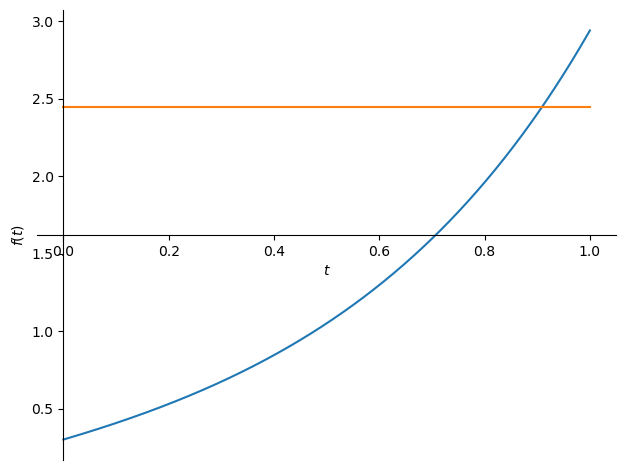

In [5]:
# График
p1 = plot(sol.rhs, (t, 0, 1), show=False)
p2 = plot(L, (t, 0, 1), show=False)
p1.extend(p2)
p1.show()

### Модель №2 (соскальзывание c сопротивлением)

Однородная цепь длиной 2.45 м соскальзывает с гладкого горизонтального стола. В начальный момент наблюдения со стола свисал участок цепи длиной 0.3 м, а скорость соскальзывания составляла 1 м/с. В дальнейшем под действием силы тяжести цепь продолжила соскальзывать со стола. Сила трения зависит от силы давления участка цепи, лежащей на столе. Коэффициент трения скольжения цепи μ = 0.1. Считая ускорение свободного падения равным 9.8 м/с² найдите **время** соскальзывания всей цепи со стола и **определите длину** свисающего участка цепи, при котором его уравновешивает сопротивление участка на столе.

In [6]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
# Начальные условия
L = 2.45
l0 = 0.3
g = 9.8
v0 = 1
mu = 0.1

t, m = symbols("t m", real=True)
l = Function("l")
v = Derivative(l, t)
a = Derivative(v, t)

In [7]:
# уравнение l'' = (g/L) * ((1 + mu)*l - mu*L)
ode = Eq(l(t).diff(t, 2), (Rational(g)/Rational(L)) * ((1 + Rational(mu))*l(t) - Rational(mu)*Rational(L)))
ode

Eq(Derivative(l(t), (t, 2)), 39631676720860365*l(t)/9007199254740992 - 9938380705789319780001047862313/10141204801825835211973625643008)

In [8]:
sol = dsolve(ode, ics={l(0): l0, l(t).diff(t).subs(t, 0): v0})
sol

Eq(l(t), 0.277002010947762*exp(sqrt(79263353441720730)*t/134217728) + 9938380705789319780001047862313/44621301128033675157863934197760 - 0.199729283675034*exp(-sqrt(79263353441720730)*t/134217728))

In [9]:
t_fall = nsolve(Eq(sol.rhs, L), t, 2).evalf()
t_fall

0.998980379872046

In [10]:
# Длина свисающего участка в равновесии
l_eq = mu * L / (1 + mu)
l_eq

0.22272727272727272

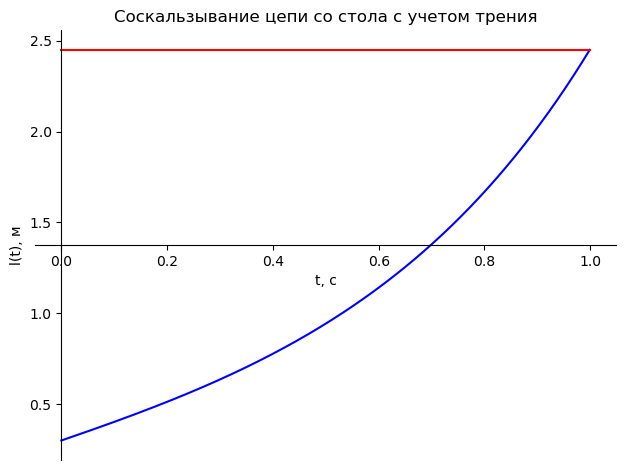

In [11]:
# График зависимости l(t)
p1 = plot(sol.rhs, (t, 0, float(t_fall)), show=False, line_color='blue', label='l(t)')
p2 = plot(L, (t, 0, float(t_fall)), show=False, line_color='red', label='L')
p1.extend(p2)
p1[0].line_color = 'blue'
p1[1].line_color = 'red'
p1.xlabel = 't, с'
p1.ylabel = 'l(t), м'
p1.title = 'Соскальзывание цепи со стола с учетом трения'
p1.show()

## Задание 2. Вертикальный взлет метеорологической ракеты

### Модель 1

Ознакомьтесь с [работой](https://doi.org/10.32517/0234-0453-2022-37-5-62-75) по моделированию запуска метеорологической ракеты МР-12.

Используя параметры ракеты, дискретное уменьшение массы топлива и формулу для аэродинамического сопротивления из работы составьте дифференциальное уравнение второго порядка, которое описывает взлет ракеты. Численно решите уравнение для разных масс с использованием `solve_ivp` до момента достижения апогея. Доведите модель до результатов схожих с представленными в работе.

In [12]:
from sympy import *
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

# параметры ракеты МР-12
M_fuel = 1200.0    # масса топлива (кг)
M_body = 250.0     # масса корпуса (кг)
thrust = 101600.0  # тяга (Н)
burn_time = 21.0   # время работы двигателя (с)
g = 9.8            # ускорение свободного падения (м/с^2)
dt = 0.1           # шаг дискретизации для массы
n = round(burn_time/dt)
fuel_rate = M_fuel / burn_time   # кг/с сгорает топлива за каждую секунду

# аэродинамическое сопротивление
def drag(v, h):
    return 0.1 * v * v * 10 ** (-0.0000555 * h)

# взлётная масса, зависящая от времени
def mass(t, payload=0.0):
    M0 = M_body + payload + M_fuel
    if t <= burn_time:
        return M0 - fuel_rate * t
    else:
        return M_body + payload

In [13]:
# ОДУ
t_sym = symbols('t', real=True)
h = Function('h')(t_sym)
v = diff(h, t_sym)
T = Function('T')(t_sym)
m = Function('m')(t_sym)
g_sym = symbols('g', positive=True)

D = drag(v, h)
ode_sym = Eq(diff(h, t_sym, 2), T/m - g_sym - sign(v)*D/m)
ode_sym

Eq(Derivative(h(t), (t, 2)), -g + T(t)/m(t) - 0.1*sign(Derivative(h(t), t))*Derivative(h(t), t)**2/(10**(5.55e-5*h(t))*m(t)))

In [14]:
def rhs(t, y, payload=0.0):
    h, v = y
    m = mass(t, payload)
    D = drag(v, h)
    if t <= burn_time:  # активный участок
        a = (thrust - D - m * g) / m
    else:  # пассивный участок
        a = (-D - m * g) / m
    return [v, a]

payload =    0.0 кг | апогей =  101.38 км | t = 150.81 c | на выгорании: h =  16098.0 м, v = 1869.05 м/с
payload =   25.0 кг | апогей =   98.44 км | t = 148.87 c | на выгорании: h =  15735.4 м, v = 1806.36 м/с
payload =   50.0 кг | апогей =   95.43 км | t = 146.81 c | на выгорании: h =  15390.1 м, v = 1749.03 м/с


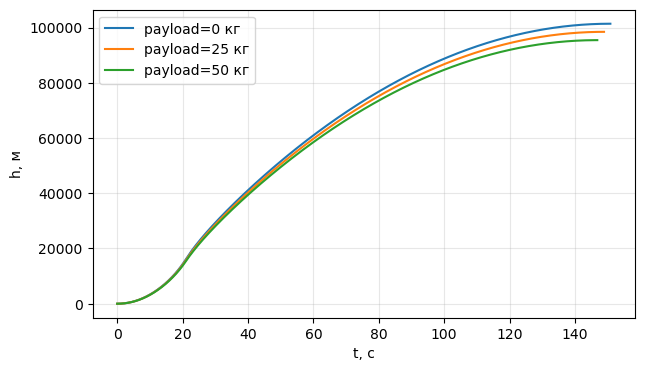

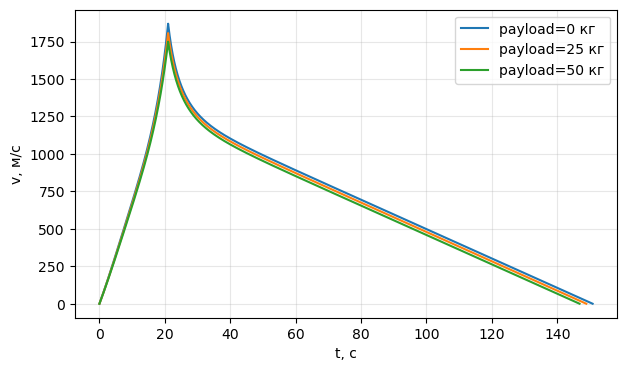

In [15]:
# событие апогея: v=0 на убывании
def apogee_event_factory(payload=0.0):
    def apogee_event(t, y):
        return y[1]
    apogee_event.terminal  = True
    apogee_event.direction = -1
    return apogee_event

def solve_ascent(rhs_t, payload=0.0, t_max=300.0, rtol=1e-7, atol=1e-9, max_step=0.05):
    y0 = [0.0, 0]
    sol = solve_ivp(lambda t, y: rhs_t(t, y, payload),
                    (0.0, t_max), y0,
                    events=apogee_event_factory(payload),
                    rtol=rtol, atol=atol, max_step=max_step, dense_output=True)
    # апогей
    if len(sol.t_events) > 0 and len(sol.t_events[0]) > 0:
        t_ap = float(sol.t_events[0][0])
        h_ap = float(sol.y_events[0][0][0])
    else:
        t_ap = float(sol.t[-1])
        h_ap = float(sol.y[0, -1])

    # значения на момент выключения двигателя
    if t_ap >= burn_time and sol.sol is not None:
        hb, vb = sol.sol(burn_time)
        hb, vb = float(hb), float(vb)
    else:
        hb, vb = np.nan, np.nan

    return {"t_apogee": t_ap, "h_apogee": h_ap, "h_burn": hb, "v_burn": vb, "sol": sol}

def run_sweep(rhs_t, payloads=(0.0, 25.0, 50.0)):
    plt.close('all')
    fig_h, ax_h = plt.subplots(figsize=(7,4))
    fig_v, ax_v = plt.subplots(figsize=(7,4))

    results = {}
    for pl in payloads:
        r = solve_ascent(rhs_t = rhs_t, payload=pl)
        results[pl] = r

        sol = r["sol"]
        ax_h.plot(sol.t, sol.y[0], label=f"payload={pl:g} кг")
        ax_v.plot(sol.t, sol.y[1], label=f"payload={pl:g} кг")

        print(f"payload = {pl:6.1f} кг | апогей = {r['h_apogee']/1000:7.2f} км | t = {r['t_apogee']:6.2f} c | "
              f"на выгорании: h = {r['h_burn']:8.1f} м, v = {r['v_burn']:7.2f} м/с")

    ax_h.set_xlabel("t, c"); ax_h.set_ylabel("h, м"); ax_h.grid(True, alpha=0.3); ax_h.legend()
    ax_v.set_xlabel("t, c"); ax_v.set_ylabel("v, м/с"); ax_v.grid(True, alpha=0.3); ax_v.legend()
    plt.show()
    return results

results = run_sweep(rhs, payloads=(0.0, 25.0, 50.0))

### Модель 2

Представленная в работе модель аэродинамического сопротивления очень упрощённая и является просто эмпирическим приближением. В реальности сопротивление зависит от плотности атмосферы, площади поперечного сечения ракеты и коэффициента аэродинамического сопротивления:

$${\displaystyle F_{\mathrm {D} }\,=\,{\tfrac {1}{2}}\,\rho \,v^{2}\,C_{\mathrm {D} }\,A}$$
где
* $\rho(h)$ - плотность воздуха на высоте $h$,
* $C_{D}$ - коэффициент аэродинамического сопротивления,
* $A$ - площадь поперечного сечения,
* $v$ - скорость ракеты.

Известен ["калибр"](https://ru.wikipedia.org/wiki/%D0%9C%D0%A0-12) ракеты, который равен 450 мм. 

В атмосфере Земли плотность атмосферы падает [почти экспоненциально](https://en.wikipedia.org/wiki/International_Standard_Atmosphere) с высотой. 

Составьте физически более правильную модель изменения плотности воздуха и, соответственно, аэродинамического сопротивления, при которой сопротивление будет уменьшаться экспоненциально с высотой и на больших высотах станет практически нулевым, как это происходит в реальности.

Поскольку параметр $A$ может быть вычислен, выполните оценку коэффициента аэродинамического сопротивления ракеты для достижения аналогичных результатов.

payload =    0.0 кг | апогей =  107.49 км | t = 159.05 c | на выгорании: h =  13997.2 м, v = 1370.16 м/с
payload =   25.0 кг | апогей =  105.44 км | t = 157.67 c | на выгорании: h =  13812.8 м, v = 1356.76 м/с
payload =   50.0 кг | апогей =  103.46 км | t = 156.31 c | на выгорании: h =  13632.9 м, v = 1343.65 м/с


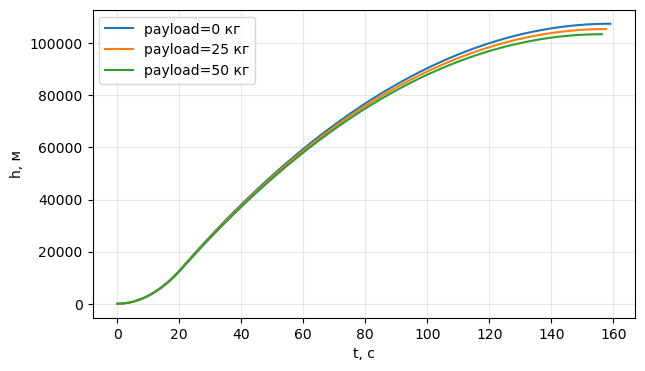

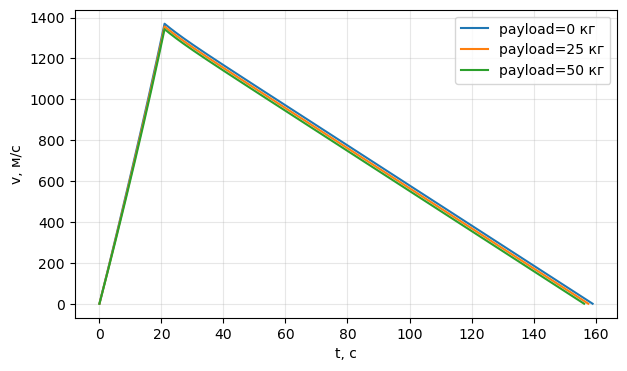

In [28]:
rho0 = 1.225        # плотность воздуха на уровне моря, кг/м³
H = 8500.0          # масштабная высота атмосферы, м
A = 0.018           # площадь поперечного сечения, м²
C_d = 0.884         # коэффициент лобового сопротивления

def rhs_new(t, y, payload):
    h, v = y
    rho = rho0 * np.exp(-h / H)
    # m = mass(t, payload)
    m0 = M_fuel+M_body+payload
    m = m0 - (m0 - M_fuel) * min(t / burn_time, 1.0)
    
    if t <= burn_time:
        a_thrust = thrust / m
    else:
        a_thrust = 0.0
    
    a_drag = -0.5 * C_d * rho * A * v * abs(v) / m
    dhdt = v
    dvdt = a_thrust + a_drag - g
    return [dhdt, dvdt]

results = run_sweep(rhs_new, payloads=(0.0, 25.0, 50.0))

# Чайник

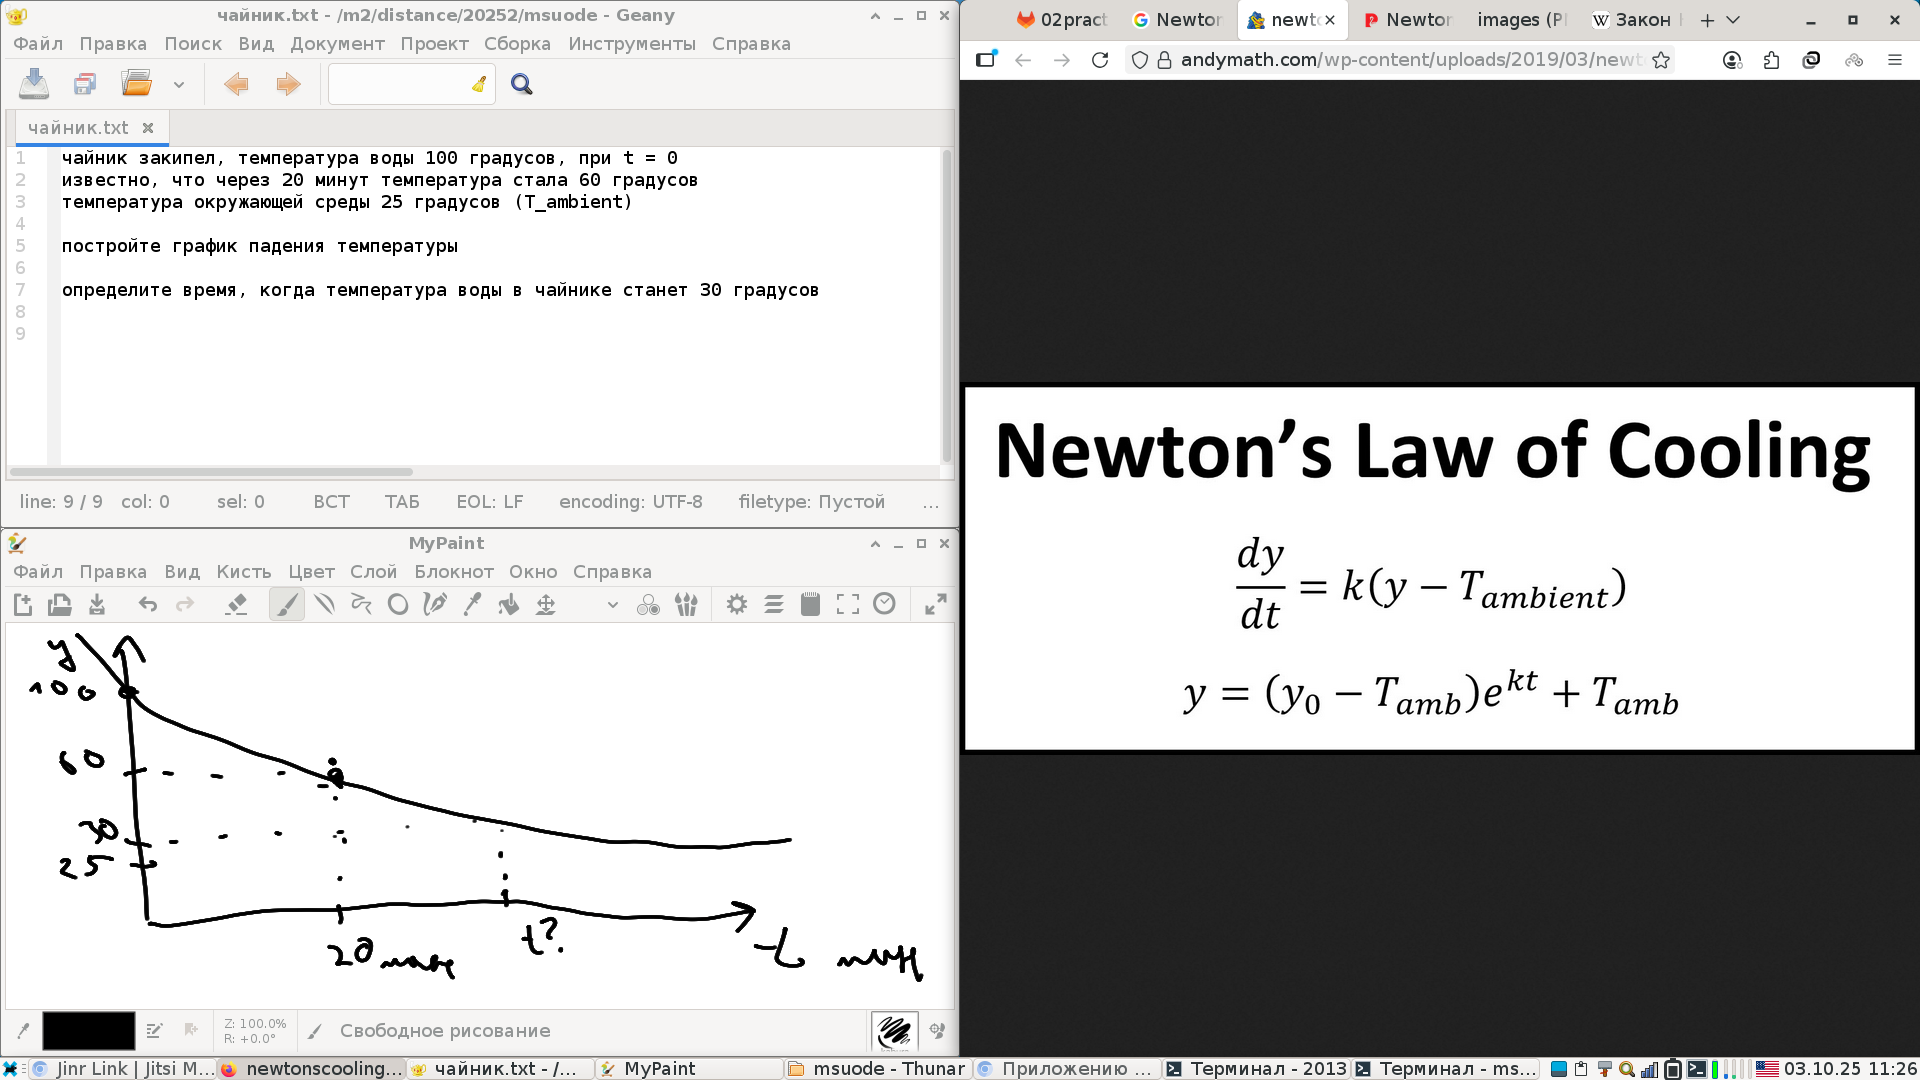

In [17]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt

t, k = symbols("t k", real=True)
y = Function('y')

# Начальные условия
T0 = 100
T_amb = 25
t1 = 20
T_t1 = 60
T_finish = 30

In [18]:
# уравнение dy/dt = k * (y - T_amb)
ode = Eq(y(t).diff(t), k*(y(t) - T_amb))
ode

Eq(Derivative(y(t), t), k*(y(t) - 25))

In [19]:
sol = dsolve(ode, ics={y(0): 100})  # нач. условие: y(0)=100
sol

Eq(y(t), 75*exp(k*t) + 25)

In [20]:
k_val = solve(Eq(sol.subs(t, t1).rhs, T_t1), k)[0]
k_val

log(15**(19/20)*7**(1/20)/15)

In [21]:
# Находим значение костанты
k_val_numeric = k_val.evalf()  
k_val_numeric

-0.0381070026023448

In [22]:
# Время, когда температура = 30 градусов
t_val = nsolve(sol.subs(k, k_val_numeric).rhs - 30, t, 25)
t_val

71.0643717996224

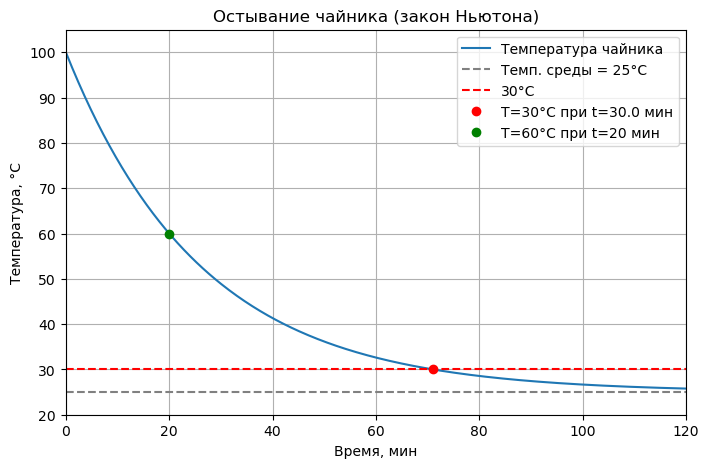

In [23]:
y_func = lambda ts: float(sol.rhs.subs({t: ts, k: k_val}))

# Массив значений времени и температуры
ts = np.linspace(0, 120, 400)
ys = [y_func(tt) for tt in ts]

# Построение графика
plt.figure(figsize=(8,5))
plt.plot(ts, ys, label="Температура чайника")
plt.axhline(T_amb, color="gray", linestyle="--", label=f"Темп. среды = {T_amb}°C")
plt.axhline(T_finish, color="red", linestyle="--", label=f"{T_finish}°C")

# Отметим точку, где T=30°C
plt.plot([float(t_val)], [T_finish], 'ro', label=f"T={T_finish}°C при t={N(T_finish,3)} мин")

# Отметим точку t1=20, T=60°C
plt.plot([t1], [T_t1], 'go', label=f"T={T_t1}°C при t={t1} мин")

plt.xlabel("Время, мин")
plt.ylabel("Температура, °C")
plt.title("Остывание чайника (закон Ньютона)")
plt.legend()
plt.grid(True)
plt.xlim(0, 120)
plt.ylim(20, 105)
plt.show()